#Market Segmentation - Cluster Analysis

## Install packages

In [ ]:
# import Python packages
import pandas as pd
import numpy as np
np.random.seed(1990)
from google.colab import files
import matplotlib.pyplot as plt
from sklearn import metrics

# Functions used to preprocess the data
from sklearn import preprocessing

# Functions used for Hierarchical Clustering
from scipy.cluster import hierarchy

# Functions used for K-Means
from sklearn import cluster

# Functions used for chi-squared test
from scipy.stats import chi2_contingency

## Data

The coffee data is simulated survey data about coffee and coffee shop preferences. There are 282 individuals in the data. For the clustering, we will focus on variables A1-A5, which are answers to the following five questions:

Rate the following on a scale from Strongly Disagree to Strongly Agree:


*   Q1: I pay close attention to the origin and sourcing of my coffee.
*   Q2: I do my best work at coffee shops.
*   Q3: A good coffee shop has free Wi-fi.
*   Q4: Good food is important in a coffee shop.
*   Q5: I enjoy drinking espresso.

In [ ]:
# import the data
uploaded = files.upload()
tablet = pd.read_csv('SelfStatedData.csv') 

Saving SelfStatedData.csv to SelfStatedData.csv


In [ ]:
# take a look at the coffee data
tablet.head(5)

,ID,Screen,Cell,OS,Battery,Price
0,1,4,5,6,6,6
1,2,6,2,5,7,6
2,3,6,1,7,4,4
3,4,5,6,5,5,5
4,5,6,2,6,7,5


In [ ]:
# select the columns that have the answers to the survey questions and store the data in df
df = tablet.drop('ID', axis=1)
df.head(5)

,Screen,Cell,OS,Battery,Price
0,4,5,6,6,6
1,6,2,5,7,6
2,6,1,7,4,4
3,5,6,5,5,5
4,6,2,6,7,5


In [ ]:
# standardize the data because distance-based methods (e.g., hierarchical clustering, k-means)
# sensitive to large differences in magnitudes between columns

df_sc = pd.DataFrame(preprocessing.scale(df),columns=df.columns)
df_sc.head(5)

,Screen,Cell,OS,Battery,Price
0,-1.328151,0.168491,0.561224,0.297129,0.164399
1,0.491234,-1.636773,-0.158294,1.079047,0.164399
2,0.491234,-2.238528,1.280741,-1.266708,-1.479591
3,-0.418459,0.770246,-0.158294,-0.484789,-0.657596
4,0.491234,-1.636773,0.561224,1.079047,-0.657596


In [ ]:
# what does scaling do?
print(df.mean())
print(df.var())
print(df_sc.mean())
print(df_sc.var())

Screen     5.46
Cell       4.72
OS         5.22
Battery    5.62
Price      5.80
dtype: float64
Screen     1.233061
Cell       2.817959
OS         1.971020
Battery    1.668980
Price      1.510204
dtype: float64
Screen     3.996803e-17
Cell       1.576517e-16
OS         1.904032e-16
Battery   -1.221245e-16
Price      1.287859e-16
dtype: float64
Screen     1.020408
Cell       1.020408
OS         1.020408
Battery    1.020408
Price      1.020408
dtype: float64


## Hierarchical Clustering

Hierarchical Clustering Analysis is one of the most popular techniques used for market segmentation. It is a numerical procedure that attempts to separate a set of observations into clusters from the bottom-up by joining single individuals sequentially until we obtain one large cluster. Hence, this technique doesn’t require the pre-specification of the number of clusters, which can be assessed through the “dendrogram” (a tree-like representation of the data).

More specifically, the algorithm works as follow:

1.   Each respondent is initially assigned to his or her own cluster
2.   Identify the distance between each cluster (intially between pairs of respondents)
3.   The two closest clusters are combined into one
4.   Repeat steps 2 and 3 until there is one unique cluster containing all the observations
5.   Represent the clusters in a dendrogram

A key aspect of hierarchical clustering is choosing how to compute the distance between two clusters. Is it equal to the maximal distance between two points from each of these clusters? Or the minimal distance? What about the distance between two points? In this handout, we will use Ward’s criterion which aims to minimize the total variance within-cluster.

In this notebook, we use scipy but scikit-learn may also be used.

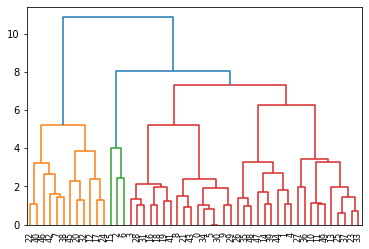

In [ ]:
linkages = hierarchy.linkage(df_sc,method='ward')
hierarchy.dendrogram(linkages)
plt.show()
# height represents dissimilarity between elements that are joined

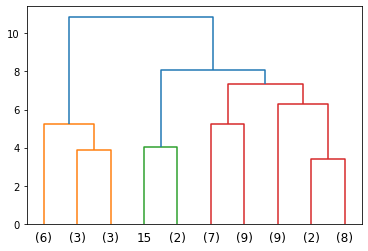

In [ ]:
hierarchy.dendrogram(linkages,orientation='top',
                     truncate_mode='lastp',p=10)
# p branches shown
plt.show()

In [ ]:
from collections import Counter
labels_hc = hierarchy.fcluster(linkages,t=7,criterion='distance')
items = Counter(labels_hc).keys()
len(items)

4

How many clusters do you think there are?
How many observations are in each cluster?



In [ ]:
labels_hc = hierarchy.fcluster(linkages,t=2,criterion='maxclust')
# labels = label for each observation
print(labels_hc[:5])
# print number of observations in each cluster
print(list(zip(*np.unique(labels_hc,return_counts=True))))
# the horizontal ordering of the clusters/observations is not meaningful

[2 2 2 2 2]
[(1, 12), (2, 38)]


How can we characterize each cluster?

In [ ]:
# function to show cluster size and calculate cluster average values
def check_clusters(data,labels):
  print(list(zip(*np.unique(labels,return_counts=True))))
  # pivot_table() calculates the mean by default
  return pd.pivot_table(data,index=labels)

check_clusters(df_sc,labels_hc)

[(1, 12), (2, 38)]


,Battery,Cell,OS,Price,Screen
1,-1.136388,-0.182532,-1.357490,0.506897,0.567042
2,0.358859,0.057642,0.428681,-0.160073,-0.179066


You can also use a distance based criterion.

In [ ]:
labels_hc = hierarchy.fcluster(linkages,t=10,criterion='distance')
# t captures the threshold for cutting the dendrogram
# labels = label for each observation
print(labels_hc[:5])
# print number of observations in each cluster
print(list(zip(*np.unique(labels_hc,return_counts=True))))

[2 2 2 2 2]
[(1, 12), (2, 38)]


How can we characterize each cluster?

In [ ]:
check_clusters(df_sc,labels_hc)

[(1, 48), (2, 82), (3, 152)]


,A1,A2,A3,A4,A5
1,1.370790,-0.584752,-2.062677,-2.071104,1.742855
2,0.805415,1.492864,0.449114,0.441528,-1.077835
3,-0.867381,-0.620702,0.409086,0.415840,0.031088


##Crosstab

We want to see what the relationship is between what type of coffee someone prefers and which cluster they are in. Let's look at a frequency table.

In [ ]:
tab = pd.crosstab(columns=labels_hc,index=coffee.PrefBev,margins=True,colnames=['Cluster'],rownames=['Coffee Type'])
tab

Cluster,1,2,3,All
Coffee Type,,,,
Coffee,19,38,72,129
Espresso,13,13,30,56
Latte,11,21,34,66
Mocha,5,10,16,31
All,48,82,152,282


## Chi-squared Test

We want to test if the relationship above is statistically significant. Is there a statistically significant difference between the expected frequencies and the observed frequencies?

Null hypothesis: There is no relationship between what type of coffee someone prefers and cluster assignment.

If the p-value is greater than 0.05, we fail to reject the null hypothesis.

In [ ]:
chi2, p, dof, expected = chi2_contingency(tab.values[:3,:4])
chi2, p, dof

Is there a significant relationship?

## K-means Clustering

We now focus on a different method called K-Means. This method, which requires us to specify in advance the number of clusters, aims to group the observations based on their similarity using an optimization procedure. The aim is to minimize the within-cluster variation, which is defined as the sum of the squared Euclidean distance between each data point to the centroid of its cluster. More precisely, the algorithm works as follow:



1.   Start by assigning each point to a cluster randomly
2.   Compute the centroid of each cluster and the distances of each point to each centroid
3.   Reassign each observation to the closest centroid
4.   Repeat Steps 2 and 3 until the within-cluster variance is minimized

In [ ]:
centroids_km, labels_km, inertia_km = cluster.k_means(df_sc,n_clusters=3,random_state=1990)
# set seed for random state so results are reproducible

In [ ]:
check_clusters(df_sc,labels_km)

[(0, 13), (1, 23), (2, 14)]


,Battery,Cell,OS,Price,Screen
0,-0.845675,0.399936,-1.154549,0.607012,0.631187
1,0.365122,0.587103,0.467374,-0.300207,-0.616218
2,0.185426,-1.335896,0.304253,-0.070457,0.426256


How do the k-means results compare to hierarchical clustering?

In [ ]:
tab = pd.crosstab(columns=labels_km,index=coffee.PrefBev,margins=True,colnames=['Cluster'],rownames=['Coffee Type'])
tab

Cluster,0,1,2,All
Coffee Type,,,,
Coffee,38,72,19,129
Espresso,13,30,13,56
Latte,21,34,11,66
Mocha,10,16,5,31
All,82,152,48,282


In [ ]:
chi2, p, dof, expected = chi2_contingency(tab.values[:3,:4])
chi2, p, dof

In [ ]:
inertia_km

158.95705089724413

### Assessing Number of Clusters

Several methods have been discussed to help determine the number of clusters one should opt for. In this notebook, we present two related approaches:

*   Inertia Plot: inertia is equal to the within cluster sum of squares. By minimizing inertia, we ensure that entities within each cluster are similar to each other. 
*   Ratio Score Plot: this plot represents the ratio of the total sum of squares (i.e., inertia when there is only one cluster) minus the within cluster sum of squares (the difference is called the between cluster sum of squares) and the total sum of squares.

Note that in the function KElbowVisualizer below, inertia is called distortion. However, in some instances, statisticians use different definitions and formulas for inertia and distortion. You must carefully review the ReadMe and sometimes the code used in a package to avoid bad surprises.




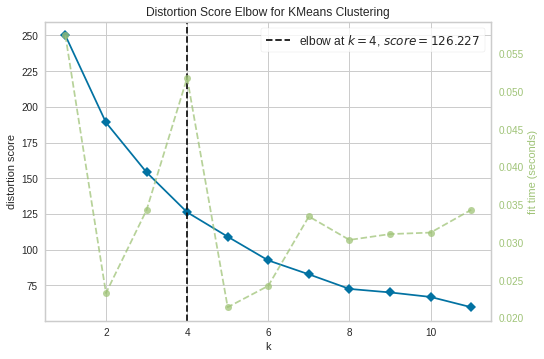

In [ ]:
from sklearn.cluster import KMeans
# k_means() is a wrapper that returns the result of KMeans.fit()
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df_sc)
visualizer.show()

In order to prepare the ratio plot, we must determine the total sum of squares which is the inertia when we only use one cluster. 

In [ ]:
ratio = []
_, _, total_sum_squares = cluster.k_means(df_sc,n_clusters=1)

for i in range(11):
  _, _, inertia_i = cluster.k_means(df_sc,n_clusters=i+1)
  ratio.append(1-(inertia_i/total_sum_squares))
  print(inertia_i)

In [ ]:
ratio = pd.DataFrame(ratio)
ratio = ratio.reset_index()
ratio['index'] = ratio['index'] + 1
ratio.columns = ['Number of Clusters','Ratio']
ratio

In [ ]:
# what's going on underneath?
# recall that inertia = total within sum of squares
np.sum((metrics.pairwise.euclidean_distances(centroids_km,np.array(df_sc.mean()).reshape(-1,1).transpose())**2).transpose()*[152,82,48])/total_sum_squares

In [ ]:
plt.plot(ratio['Number of Clusters'],ratio['Ratio'],marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Ratio')
plt.title('Ratio Plot')